In [1]:
#Import Libraries
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet152
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras import layers
import tensorflow as tf
import numpy as np

In [2]:
#load the directories
training_dir = '../input/twoclasses/BinDataset/Training'
val_dir = '../input/twoclasses/BinDataset/Validation'

In [3]:
#Variables declaration
IMG_SIZE = (224,224)
EPOCHS   = 100
BATCH_SIZE  = 128
RANDOM_SEED = 1403
augmentation     = True
rotation_range   = 0.1
zoom_range       = 0.1
shear_range      = 0.1
fill_mode        = 'nearest'

In [4]:
if augmentation:
    train_datagen   = ImageDataGenerator(preprocessing_function = preprocess_input,
                                         rotation_range     = rotation_range,
                                         zoom_range         = zoom_range,
                                         shear_range        = shear_range,
                                         fill_mode          = fill_mode)
else:
    train_datagen   = ImageDataGenerator(preprocessing_function = preprocess_input)

val_datagen         = ImageDataGenerator(preprocessing_function = preprocess_input)

In [5]:
train_data = train_datagen.flow_from_directory(
    training_dir,
    target_size = IMG_SIZE,
    color_mode  = 'rgb',
    class_mode  = 'binary',
    shuffle     = 'True',
    batch_size  = BATCH_SIZE,
    seed        = RANDOM_SEED
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size = IMG_SIZE,
    color_mode  = 'rgb',
    class_mode  = 'binary',
    shuffle     = 'True',
    batch_size  = BATCH_SIZE,
    seed        = RANDOM_SEED
)

Found 6829 images belonging to 2 classes.
Found 2101 images belonging to 2 classes.


# Model

In [6]:
def create_compile_fit_model(model_name):
    if(model_name == 'ResNet152'):
        base_model = ResNet152(weights ='imagenet', include_top = False, input_shape = IMG_SIZE + (3,))
    if(model_name == 'VGG16'):
        base_model = VGG16(weights ='imagenet', include_top = False, input_shape = IMG_SIZE + (3,))
    if(model_name == 'VGG19'):
        base_model = VGG19(weights ='imagenet', include_top = False, input_shape = IMG_SIZE + (3,))

    model = Sequential()
    model.add(base_model)
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.layers[0].trainable = False

    #Compile the model
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    #Stopping criteria
    es     = EarlyStopping(monitor = 'val_loss', mode = 'min',patience = 10)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor = np.sqrt(0.1), patience = 5,cooldown = 0, min_lr = 0.5e-6)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./binary_pretrained_' + model_name + '.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')

    #Fit the model
    hist = model.fit(train_data, batch_size = BATCH_SIZE, epochs = EPOCHS, shuffle = True,
                     validation_data = val_data,callbacks = [es, model_checkpoint, reduce_lr], verbose = 1)

    return model, hist

# Plot

In [7]:
#Plot training-validation accuracy and loss
def plot_accuracy_loss(hist):

    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    print("Maximum Accuracy of Train Set {}".format(max(train_acc)))
    print("Maximum Accuracy of Validation Set {}".format(max(val_acc)))

    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    print("\nMinimum Loss of Train Set {}".format(min(train_loss)))
    print("Minimum Loss of Validation Set {}".format(min(val_loss)))

    #plot the accuracy and loss of training-validation sets
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel("Accuracy-Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation Loss"])
    plt.show()

    
#Plot learning rate
def plot_learning_rate(hist):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['lr'], 'o-')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')

# VGG-16 model

In [8]:
#VGG-16 Model
vgg16_model, vgg16_history = create_compile_fit_model('VGG16')

2022-03-19 08:01:00.902940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 08:01:00.988366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 08:01:00.989030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 08:01:00.990140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


2022-03-19 08:01:06.109785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-19 08:01:09.600912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 [==============================] - 138s 2s/step - loss: 0.3337 - accuracy: 0.8421 - val_loss: 0.3233 - val_accuracy: 0.8743
Epoch 2/100
54/54 [==============================] - 86s 2s/step - loss: 0.1516 - accuracy: 0.9444 - val_loss: 0.1290 - val_accuracy: 0.9481
Epoch 3/100
54/54 [==============================] - 86s 2s/step - loss: 0.1061 - accuracy: 0.9668 - val_loss: 0.0926 - val_accuracy: 0.9667
Epoch 4/100
54/54 [==============================] - 85s 2s/step - loss: 0.0840 - accuracy: 0.9725 - val_loss: 0.0730 - val_accuracy: 0.9757
Epoch 5/100
54/54 [==============================] - 86s 2s/step - loss: 0.0722 - accuracy: 0.9764 - val_loss: 0.0609 - val_accuracy: 0.9805
Epoch 6/100
54/54 [==============================] - 85s 2s/step - loss: 0.0670 - accuracy: 0.9783 - val_loss: 0.0516 - val_accuracy: 0.9819
Epoch 7/100
54/54 [==============================] - 86s 2s/step - loss: 0.0639 - accuracy: 0.9818 - val_loss: 0.0465 - val_accuracy: 0.9852
Epoch 8/100
54/54 [=====

In [9]:
#Summary of VGG-16 model
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,840,129
Trainable params: 75,265
Non-trainable params: 14,764,864
_______________________________________

Maximum Accuracy of Train Set 0.9898960590362549
Maximum Accuracy of Validation Set 0.9904807209968567

Minimum Loss of Train Set 0.03252314031124115
Minimum Loss of Validation Set 0.038105178624391556


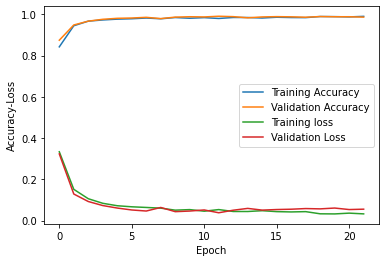

In [10]:
#plot accuracy-loss of training-validation set
plot_accuracy_loss(vgg16_history)

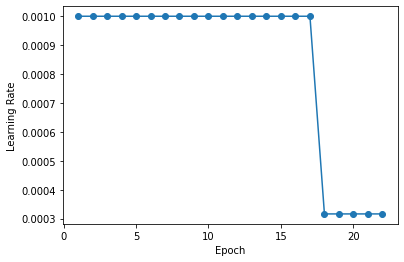

In [11]:
#plot learning rate to see how drop it
plot_learning_rate(vgg16_history)

In [12]:
#save the best fit of VGG-16 model
vgg16_model.save('./binary_pretrained_VGG16.h5')

# VGG-19 Model

In [13]:
#VGG-19 Model
vgg19_model, vgg19_history = create_compile_fit_model('VGG19')

80150528/80134624 [==============================] - 0s 0us/step
Epoch 1/100
54/54 [==============================] - 90s 2s/step - loss: 0.3179 - accuracy: 0.8490 - val_loss: 0.1578 - val_accuracy: 0.9357
Epoch 2/100
54/54 [==============================] - 88s 2s/step - loss: 0.1475 - accuracy: 0.9455 - val_loss: 0.1266 - val_accuracy: 0.9467
Epoch 3/100
54/54 [==============================] - 87s 2s/step - loss: 0.1051 - accuracy: 0.9635 - val_loss: 0.0731 - val_accuracy: 0.9748
Epoch 4/100
54/54 [==============================] - 88s 2s/step - loss: 0.0913 - accuracy: 0.9672 - val_loss: 0.0810 - val_accuracy: 0.9719
Epoch 5/100
54/54 [==============================] - 88s 2s/step - loss: 0.0769 - accuracy: 0.9744 - val_loss: 0.0689 - val_accuracy: 0.9743
Epoch 6/100
54/54 [==============================] - 89s 2s/step - loss: 0.0641 - accuracy: 0.9780 - val_loss: 0.0539 - val_accuracy: 0.9805
Epoch 7/100
54/54 [==============================] - 89s 2s/step - loss: 0.0620 - accurac

In [14]:
#Summary of VGG-19 model
vgg19_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 20,149,825
Trainable params: 75,265
Non-trainable params: 20,074,560
_____________________________________

Maximum Accuracy of Train Set 0.9897496104240417
Maximum Accuracy of Validation Set 0.9890528321266174

Minimum Loss of Train Set 0.02614770084619522
Minimum Loss of Validation Set 0.029537271708250046


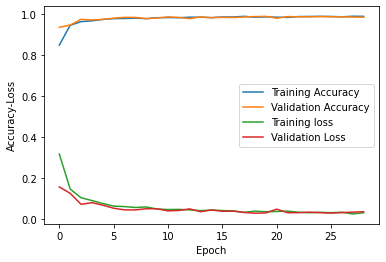

In [15]:
#plot accuracy-loss of training-validation set
plot_accuracy_loss(vgg19_history)

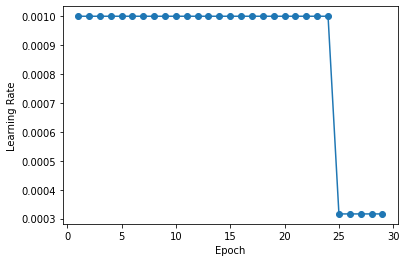

In [16]:
#plot learning rate to see how drop it
plot_learning_rate(vgg19_history)

In [17]:
#save the best fit of VGG-19 model
vgg19_model.save('./binary_pretrained_VGG19.h5')

# ResNet-152 Model

In [18]:
#ResNet-152 Model
resnet152_model, resnet152_history = create_compile_fit_model('ResNet152')

234708992/234698864 [==============================] - 2s 0us/step
Epoch 1/100
54/54 [==============================] - 106s 2s/step - loss: 0.2710 - accuracy: 0.8928 - val_loss: 0.1045 - val_accuracy: 0.9619


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
54/54 [==============================] - 96s 2s/step - loss: 0.0735 - accuracy: 0.9692 - val_loss: 0.0927 - val_accuracy: 0.9634
Epoch 3/100
54/54 [==============================] - 96s 2s/step - loss: 0.0444 - accuracy: 0.9842 - val_loss: 0.0772 - val_accuracy: 0.9714
Epoch 4/100
54/54 [==============================] - 95s 2s/step - loss: 0.0527 - accuracy: 0.9813 - val_loss: 0.0399 - val_accuracy: 0.9838
Epoch 5/100
54/54 [==============================] - 96s 2s/step - loss: 0.0279 - accuracy: 0.9890 - val_loss: 0.0754 - val_accuracy: 0.9710
Epoch 6/100
54/54 [==============================] - 96s 2s/step - loss: 0.0288 - accuracy: 0.9896 - val_loss: 0.0296 - val_accuracy: 0.9867
Epoch 7/100
54/54 [==============================] - 96s 2s/step - loss: 0.0294 - accuracy: 0.9892 - val_loss: 0.0785 - val_accuracy: 0.9738
Epoch 8/100
54/54 [==============================] - 96s 2s/step - loss: 0.0241 - accuracy: 0.9914 - val_loss: 0.0706 - val_accuracy: 0.9786
Epoch 9/100
5

In [19]:
#Summary of ResNet-152 model
resnet152_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100352)            401408    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 100353    
Total params: 58,872,705
Trainable params: 301,057
Non-trainable params: 58,571,648
____________________________________

Maximum Accuracy of Train Set 0.999121367931366
Maximum Accuracy of Validation Set 0.9957163333892822

Minimum Loss of Train Set 0.002982894191518426
Minimum Loss of Validation Set 0.015427903272211552


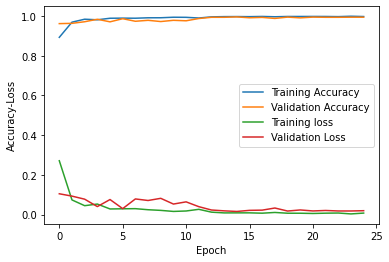

In [20]:
#plot accuracy-loss of training-validation set
plot_accuracy_loss(resnet152_history)                                                                              

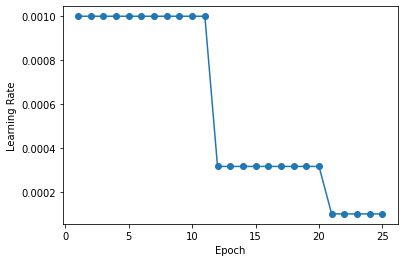

In [21]:
#plot learning rate to see how drop it
plot_learning_rate(resnet152_history)

In [22]:
#save the best fit of ResNet-152 model
resnet152_model.save('./binary_pretrained_ResNet152.h5')

# Performance Evaluation

In [23]:
#Import Libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import keras

In [24]:
#load the directory
test_dir = '../input/twoclasses/BinDataset/Test'

In [25]:
#Test Data Generator
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMG_SIZE,
    color_mode  = 'rgb',
    class_mode  = 'binary',
    shuffle     = 'False',
    seed        = RANDOM_SEED
)

Found 1575 images belonging to 2 classes.


In [26]:
#Evaluate on each set
def accuracy_loss_evaluation(model):
    
    train_score = model.evaluate(train_data)
    val_score = model.evaluate(val_data)
    test_score = model.evaluate(test_data)
    
    print('\nTraining loss {:.4f}, accuracy {:.2f}%'.format(train_score[0], train_score[1] * 100))
    print('Validation loss {:.4f}, accuracy {:.2f}%'.format(val_score[0], val_score[1] * 100))
    print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

    
#True and predicted value calculation
def true_prediction_calculation(model):
    predictions = []
    true        = []
    ctr         = 0
    for batch, label in test_data:
        prediction = model.predict(batch)
        prediction = [1 if x > 0.5 else 0 for x in prediction]
        predictions.extend(prediction)
        true.extend(label)
        ctr += len(prediction)
        if ctr >= len(test_data.labels):
            break
          
    return true, predictions


class_labels = list(test_data.class_indices.keys())

#Plot Confusion Matrix 
def plot_confusion_matirix(true, predictions):   
    matrix    = confusion_matrix(true, predictions)
    fig, axes = plt.subplots()

    axes.imshow(matrix, cmap = plt.get_cmap('Oranges'))
    for (i, j), e in np.ndenumerate(matrix):
        axes.text(j, i, s = str(e), ha='center', va = 'center')
    axes.set_xticks(np.arange(0, len(class_labels), 1))
    axes.set_xticklabels(class_labels)
    axes.set_yticks(np.arange(0, len(class_labels), 1))
    axes.set_yticklabels(class_labels)
    #axes.set_title('Confusion Matrix')
    plt.show()


#Plot ROC curve
def plot_roc_curve(true, predictions):

    FPR, TPR, _ = roc_curve(true, predictions)
    roc_auc = auc(FPR, TPR)

    plt.plot(FPR, TPR, color = 'darkorange', label = 'ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0,1], [0,1], color = 'navy', linestyle = '--')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.legend(loc = "lower right")
    plt.show()
    
    
#Accuracy, Precision, Recall, F1-score, Classification Report, ROC curve
def performance_evaluation(true, predictions):

    plot_confusion_matirix(true, predictions)

    print('\n\nAccuracy: {:.4f}\n'.format(accuracy_score(true, predictions)))
    print('Precision: {:.4f}'.format(precision_score(true, predictions)))
    print('Recall: {:.4f}'.format(recall_score(true, predictions)))
    print('F1-score: {:.4f}\n'.format(f1_score(true, predictions)))

    print('Classification Report:\n')
    print(classification_report(true, predictions, target_names = class_labels))

    print('\n')
    plot_roc_curve(true, predictions)

# VGG-16 Model

In [27]:
#Load VGG-16 Model
#vgg16_model = keras.models.load_model('./binary_pretrained_VGG16.h5')

In [28]:
#accuracy-loss of each set for VGG-16 model
accuracy_loss_evaluation(vgg16_model)

50/50 [==============================] - 13s 203ms/step - loss: 0.0606 - accuracy: 0.9860

Training loss 0.0104, accuracy 99.90%
Validation loss 0.0555, accuracy 98.62%
Test loss 0.0606, accuracy 98.60%


In [29]:
#Calculate true and predicted value
vgg16_y_true, vgg16_y_pred = true_prediction_calculation(vgg16_model)

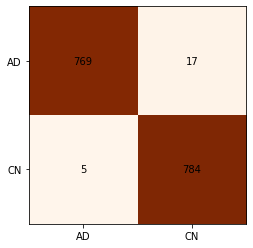



Accuracy: 0.9860

Precision: 0.9788
Recall: 0.9937
F1-score: 0.9862

Classification Report:

              precision    recall  f1-score   support

          AD       0.99      0.98      0.99       786
          CN       0.98      0.99      0.99       789

    accuracy                           0.99      1575
   macro avg       0.99      0.99      0.99      1575
weighted avg       0.99      0.99      0.99      1575





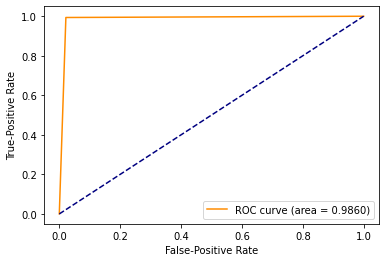

In [30]:
#Performance Evaluation of VGG-16 model
performance_evaluation(vgg16_y_true, vgg16_y_pred)

# VGG-19 Model

In [31]:
#Load VGG-19 Model
#vgg19_model = keras.models.load_model('./binary_pretrained_VGG19.h5')

In [32]:
#accuracy-loss of each set for VGG-19 model
accuracy_loss_evaluation(vgg19_model)

50/50 [==============================] - 4s 87ms/step - loss: 0.0446 - accuracy: 0.9829

Training loss 0.0080, accuracy 99.85%
Validation loss 0.0368, accuracy 98.52%
Test loss 0.0446, accuracy 98.29%


In [33]:
#Calculate true and predicted values
vgg19_y_true, vgg19_y_pred = true_prediction_calculation(vgg19_model)

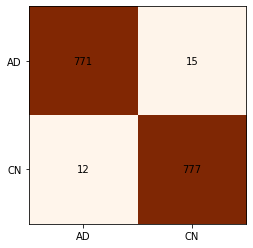



Accuracy: 0.9829

Precision: 0.9811
Recall: 0.9848
F1-score: 0.9829

Classification Report:

              precision    recall  f1-score   support

          AD       0.98      0.98      0.98       786
          CN       0.98      0.98      0.98       789

    accuracy                           0.98      1575
   macro avg       0.98      0.98      0.98      1575
weighted avg       0.98      0.98      0.98      1575





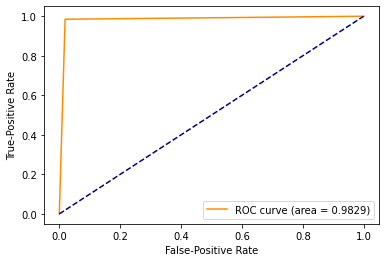

In [34]:
#Performance Evaluation of VGG-19 model
performance_evaluation(vgg19_y_true, vgg19_y_pred)

# ResNet-152 Model

In [35]:
#Load ResNet-152 Model
#resnet152_model = keras.models.load_model('./binary_pretrained_VGG19.h5')

In [36]:
#accuracy-loss of each set for VGG-19 model
accuracy_loss_evaluation(resnet152_model)

50/50 [==============================] - 8s 145ms/step - loss: 0.0498 - accuracy: 0.9886

Training loss 0.0007, accuracy 100.00%
Validation loss 0.0192, accuracy 99.43%
Test loss 0.0498, accuracy 98.86%


In [37]:
#Calculate true and predicted values
resnet152_y_true, resnet152_y_pred = true_prediction_calculation(resnet152_model)

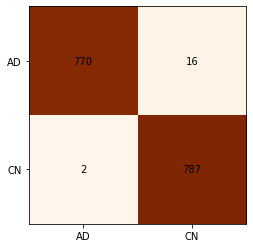



Accuracy: 0.9886

Precision: 0.9801
Recall: 0.9975
F1-score: 0.9887

Classification Report:

              precision    recall  f1-score   support

          AD       1.00      0.98      0.99       786
          CN       0.98      1.00      0.99       789

    accuracy                           0.99      1575
   macro avg       0.99      0.99      0.99      1575
weighted avg       0.99      0.99      0.99      1575





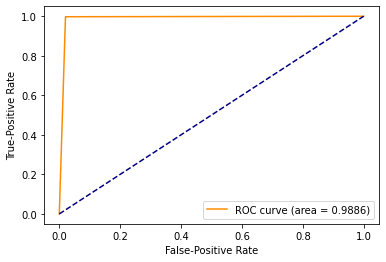

In [38]:
#Performance Evaluation of ResNet-152 model
performance_evaluation(resnet152_y_true, resnet152_y_pred)